# 非参数检验（第一部分）

到目前为止，你在设计和分析实验时，对正态分布的均值采用的都是标准假设检验。但是，有时候不能只依赖于标准检验。原因可能是不确定指标分布的真实变化性、缺少满足正态要求的数据，或者想对缺少标准检验的统计量进行推理。这时候就有必要了解一些**非参数检验**，不仅仅是为了处理上述情况，而且可以作为实验结果的辅助检查工具。非参数检验的主要优势是，它们不依赖于对底层总体做出很多假设，与标准检验相比，非参数检验适用于更广泛的情形。在此 notebook 中，你将学习两种非参数检验方法，这两种方法会对数据重新抽样，并对分布和差异做出推理。

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 自助法

自助法会使用实际收集的数据生成假设会收集的新样本，并估算抽样分布情况。在标准自助法中，自助样本是指从原始数据中抽出放回地抽取数据点，直到获得和原始数据一样多的数据点。本质上，我们将原始数据当做总体：不对原始总体分布做出假设，我们最多只能使用原始数据作为总体模型。

获取很多自助样本使我们能够针对原始数据的各种统计量估算抽样分布。例如，假设我们想对数据集（有 5000 个数据）中的第 90 百分位数值创建 95% 的置信区间。（也许我们查看的是网站加载时间，想要减少最糟糕的情况。）通过自助法，可以轻松地估算结果。首先，我们进行自助抽样（即从原始数据中抽出放回地抽取 5000 个数据点），记录第 90 百分位数值，然后重复这一过程很多次，例如 100 000 次。根据这么多自助的第 90 百分位估算值，我们算出估算值的中心 95% 区域对应的值（截取首尾 2.5% 的区域），并获得 95% 的置信区间。请根据以下步骤在下面的单元格中实现这一过程：

- 初始化一些有用的变量，将数据点的数量存储在 `n_points` 中，并用 `sample_qs` 创建一个自助分位数值空列表。
- 为每个试验创建一个循环：
  - 首先从数据中抽出放回地抽取数据，生成自助样本。（可以使用[`random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。）
  - 然后，计算样本的第 `q` 分位数，并将其添加到 `sample_qs` 列表中。如果你使用的是 NumPy v0.15 或更高版本，可以使用 [`quantile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.quantile.html) 函数直接获取 `q` 的分为数，在 v0.14 或更低版本中，你需要将 `q` 变成百分位数并使用 [`percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)。
- 收集自助的分位数后，找到捕获分位数中心 `c` 比例的上下限，从而得出估算的置信区间。

In [3]:
def quantile_ci(data, q, c = .95, n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        data: data in form of 1-D array-like (e.g. numpy array or Pandas series)
        q: quantile to be estimated, must be between 0 and 1
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
    
    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points = data.shape[0]
    sample_qs = []
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = np.random.choice(data, n_points, replace = True)
        
        # compute the desired quantile...
        sample_q = np.percentile(sample, 100 * q)
        
        # and add the value to the list of sampled quantiles
        sample_qs.append(sample_q)
        
    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_qs, (1 - c)/2 * 100)
    upper_limit = np.percentile(sample_qs, (1 + c)/2 * 100)
    
    return (lower_limit, upper_limit)

In [5]:
data = pd.read_csv('data/bootstrapping_data.csv')
data.head(5)

,time
0,8152
1,2082
2,3049
3,3317
4,813


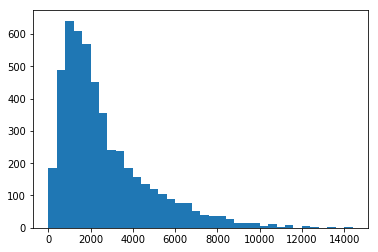

In [6]:
# data visualization
plt.hist(data['time'], bins = np.arange(0, data['time'].max()+400, 400));

In [7]:
lims = quantile_ci(data['time'], 0.9)
print(lims)

(5495.292500000001, 5832.0)


### 自助法注意事项

与真实世界相比，通过自助法获得的置信区间更加乐观。这是因为我们没有关于真实世界的参数化模型，对于真实世界还有一些不了解的情况。思考下尝试了解最大值分布的极端情形：置信区间永远无法包含大于最大观察值的值，并且下限小于最大观察值是不合理的。但是，很有可能有一些未观察到的值大于我们观察到的值，尤其是像示例中所演示的偏斜数据。

但是这并不能否定自助法的优势。自助流程很简单直白。由于不对数据分布做出假设，所以适用于任何情形。结果应该与标准检验的不相上下。但是需要投入计算精力，并且输出取决于输入数据。例如，对于上述示例中第 90 百分位上的 95% 置信区间，推断的区间只能捕获原始生成分布中约 83% 的第 90 百分位数值。但是使用更复杂的二项假设对观察到的数据编制索引，只能使结果提高一个百分点，达到 84%。这两种方法都取决于生成的具体数据：不同的 5000 个数据点将生成不同的区间，准确率也不同。

百分位置信区间的二项式方法参考文档：[1](https://www-users.york.ac.uk/~mb55/intro/cicent.htm)、[2](https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile)

## 置换检验

置换检验是一种重新抽样检验，用于比较两组或多组之间的结果变量的值。在置换检验中，我们对组标签进行重新抽样。原理是，在零假设下，所有组的结果分布应该一样，无论是对照组还是实验组。所以，我们可以将所有数据值当做一个大的小组，并模拟零假设。将标签随机地分配给数据点（同时保持原始小组成员比例）可以得出零假设的一个模拟结果。

剩下的步骤与标准假设检验中使用的抽样方法类似，但是我们尚未指定要从中抽样的参考分布，我们直接从收集的数据中抽样。将标签随机分配给所有数据并多次记录结果统计量后，我们将实际观察到的统计量与模拟统计量进行比较。我们看看有多少模拟统计值和实际观察到的统计值一样极端或更极端，并算出 p 值，然后得出结论。

请在下面的单元格中实现置换检验，检验与对照组相比，实验组的次数第 90 百分位是否统计显著性地更小：

- 初始化一个空列表，用于将样本分位数的差异存储为 `sample_diffs`。
- 为每个试验创建一个循环：
  - 首先通过随机重排数据点标签，生成一个置换样本。（可以使用[`random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html)。）
  - 然后，根据置换的标签计算分配给每组的数据点的第 `q` 分位数。将分位数差异附加到 `sample_diffs` 列表中。
- 收集置换样本的分位数差异后，计算实际数据观察到的差异。然后，看看有多少置换样本差异小于或大于观察到的差异，并计算 p 值，具体取决于期望的备择假设。

In [8]:
def quantile_permtest(x, y, q, alternative = 'less', n_trials = 10_000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        x: 1-D array-like of data for independent / grouping feature as 0s and 1s
        y: 1-D array-like of data for dependent / output feature
        q: quantile to be estimated, must be between 0 and 1
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    """
    
    
    # initialize storage of bootstrapped sample quantiles
    sample_diffs = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        labels = np.random.permutation(y)
        
        # compute the difference in quantiles
        cond_q = np.percentile(x[labels == 0], 100 * q)
        exp_q  = np.percentile(x[labels == 1], 100 * q)
        
        # and add the value to the list of sampled differences
        sample_diffs.append(exp_q - cond_q)
    
    # compute observed statistic
    cond_q = np.percentile(x[y == 0], 100 * q)
    exp_q  = np.percentile(x[y == 1], 100 * q)
    obs_diff = exp_q - cond_q
    
    # compute a p-value
    if alternative == 'less':
        hits = (sample_diffs <= obs_diff).sum()
    elif alternative == 'greater':
        hits = (sample_diffs >= obs_diff).sum()
    
    return (hits / n_trials)

In [9]:
data = pd.read_csv('data/permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


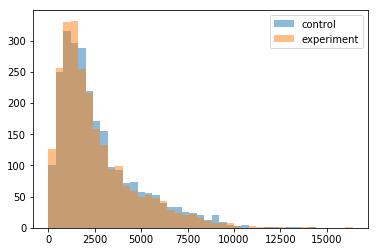

In [10]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [11]:
# Just how different are the two distributions' 90th percentiles?
print(np.percentile(data[data['condition'] == 0]['time'], 90),
      np.percentile(data[data['condition'] == 1]['time'], 90))

5809.199999999999 5492.2


In [12]:
quantile_permtest(data['time'], data['condition'], 0.9,
                  alternative = 'less')

0.0298

```python

```